In [37]:
import scipy.io as sio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

mat_content = sio.loadmat('assets/face.mat')
mat_content # Let's see the content...

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Sat May 27 02:07:24 2006',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[106, 130, 191, ...,  70, 183,  77],
        [103, 129, 185, ...,  62, 250,  72],
        [103, 130, 174, ...,  83, 163,  68],
        ...,
        [ 37,  40,  22, ...,  87, 102,  93],
        [ 36,  36,  19, ...,  89,  95, 103],
        [ 41,  35,  17, ...,  94, 106, 110]], dtype=uint8),
 'l': array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12, 13,

In [2]:
# train, test data split

face_data = mat_content['X']
face_labels = mat_content['l']

x_train = []
x_test = []

y_train = []
y_test = []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class
    
    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train = np.hstack(x_train)
x_test = np.hstack(x_test)
y_train = np.hstack(y_train)
y_test = np.hstack(y_test)



# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


In [23]:
x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)

**PCA-LDA**

In [24]:
# 클래스별로 x_train을 쪼개는 함수

def split_by_class(x_train, y_train):
    y_train = y_train.flatten()
    classes = np.unique(y_train)  # 고유 클래스 값들
    class_dict = {}
    
    for cls in classes:
        # 해당 클래스에 해당하는 인덱스 필터링
        indices = np.where(y_train == cls)[0]
        # 클래스별 x_train 데이터를 딕셔너리에 저장
        class_dict[cls] = x_train[:, indices]
    
    return class_dict

# 클래스별로 분리된 x_train
class_split_x_train = split_by_class(x_train, y_train)
class_split_x_train = np.array(list(class_split_x_train.values()))

In [25]:
# compute the mean vector

class_mean = np.mean(class_split_x_train, axis=2) #(52,2576)
overall_mean = np.mean(x_train, axis=1).reshape(-1,1) #(2576, 1)

In [26]:
# within-class scatter matrix, between-class scatter matrix, total scatter matrix

n_features = x_train.shape[0]
Sb = np.zeros((n_features, n_features))
Sw = np.zeros((n_features, n_features))

# total scatter matrix
T = x_train - overall_mean
St = np.matmul(T, T.T) / (T.shape[1]-1)

for i in range(class_split_x_train.shape[2]):
    X = class_split_x_train[i]
    N = X.shape[1]
    
    # between-class scatter matrix
    mean_diff = class_mean[i].reshape(-1, 1) - overall_mean #(2576, 1)
    Sb += N * (mean_diff).dot(mean_diff.T)
    
    # within-class scatter matrix
    for j in range(X.shape[1]):
        x = X[:, j]
        x = x.reshape(n_features, 1)
        mean = class_mean[i].reshape(n_features, 1)
        Sw += (x - mean).dot((x - mean).T)

In [27]:
#################################
# ranks of the scatter matrices #
#################################

# between-class scatter matrix
rank_b = np.linalg.matrix_rank(Sb)
print('rank of between-class scatter matrix: ', rank_b)

# within-class scatter matrix
rank_w = np.linalg.matrix_rank(Sw)
print('rank of within-class scatter matrix: ', rank_w)

# total scatter matrix
rank_t = np.linalg.matrix_rank(St)
print('rank of total scatter matrix: ', rank_t)

rank of between-class scatter matrix:  8
rank of within-class scatter matrix:  56
rank of total scatter matrix:  415


In [28]:
# PCA
M_pca = 100

eigvals, eigvecs = np.linalg.eigh(St)

sorted_indices = np.argsort(eigvals)[::-1]

eigvals = eigvals[sorted_indices] #(2576,)
eigvecs = eigvecs[:, sorted_indices] #(2576, 2576)

W_pca = eigvecs[:, :M_pca] #(2576, M_pca)
A_pca = np.matmul(W_pca.T, T) #(M_pca, 416)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


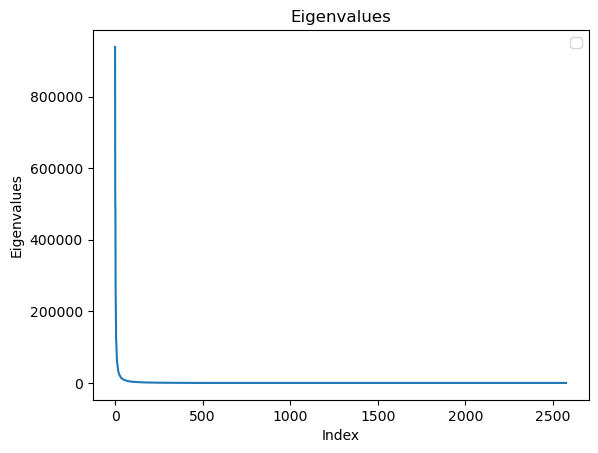

In [29]:
# Plot the arrays
plt.plot(eigvals)

# Add title and labels
plt.title("Eigenvalues")
plt.xlabel("Index")
plt.ylabel("Eigenvalues")

# Add a legend to distinguish the arrays
plt.legend()

# Show the plot
plt.show()

In [31]:
# LDA
M_lda = 51

S_lda = np.linalg.inv(W_pca.T @ Sw @ W_pca) @ (W_pca.T @ Sb @ W_pca)

eigvals, eigvecs = np.linalg.eigh(S_lda)

sorted_indices = np.argsort(eigvals)[::-1]

eigvals = eigvals[sorted_indices] #(M_pca,)
eigvecs = eigvecs[:, sorted_indices] #(M_pca, M_pca)

W_lda = eigvecs[:, :M_lda] #(M_pca, M_lda)

W_opt = np.matmul(W_pca, W_lda) #(2576, M_lda)
A = np.matmul(W_opt.T, T) #(M_lda, 416)

In [32]:
# Reconstruction

# train
x_train_rec = overall_mean + np.matmul(W_opt, A) #(2576, 416)

# test
T_test = x_test - overall_mean
A_test = np.matmul(W_opt.T, T_test) #(M_lda, 104)
x_test_rec = overall_mean + np.matmul(W_opt, A_test) #(2576, 104)

rec_err_train = np.mean(np.abs(x_train - x_train_rec))
print(f"Train Reconstruction Error: {rec_err_train}")

rec_err_test = np.mean(np.abs(x_test - x_test_rec))
print(f"Test Reconstruction Error: {rec_err_test}")

Train Reconstruction Error: 22.88608977502502
Test Reconstruction Error: 23.059603197031617


**PCA-LDA based face recognition with the NN classifier**

In [33]:
def PCA_LDA(x_train, y_train, M_pca, M_lda):
    class_split_x_train = split_by_class(x_train, y_train)
    class_split_x_train = np.array(list(class_split_x_train.values()))
    
    class_mean = np.mean(class_split_x_train, axis=2) #(52,2576)
    overall_mean = np.mean(x_train, axis=1).reshape(-1,1) #(2576, 1)

    n_features = x_train.shape[0]
    Sb = np.zeros((n_features, n_features))
    Sw = np.zeros((n_features, n_features))

    # total scatter matrix
    T = x_train - overall_mean
    St = np.matmul(T, T.T) / (T.shape[1]-1)

    for i in range(class_split_x_train.shape[2]):
        X = class_split_x_train[i]
        N = X.shape[1]
        
        # between-class scatter matrix
        mean_diff = class_mean[i].reshape(-1, 1) - overall_mean #(2576, 1)
        Sb += N * (mean_diff).dot(mean_diff.T)
        # within-class scatter matrix
        for j in range(X.shape[1]):
            x = X[:, j]
            x = x.reshape(n_features, 1)
            mean = class_mean[i].reshape(n_features, 1)
            Sw += (x - mean).dot((x - mean).T)

    # PCA
    eigvals, eigvecs = np.linalg.eigh(St)
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices] #(2576,)
    eigvecs = eigvecs[:, sorted_indices] #(2576, 2576)
    W_pca = eigvecs[:, :M_pca] #(2576, M_pca)

    # LDA
    S_lda = np.linalg.inv(W_pca.T @ Sw @ W_pca) @ (W_pca.T @ Sb @ W_pca)
    eigvals, eigvecs = np.linalg.eigh(S_lda)
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices] #(M_pca,)
    eigvecs = eigvecs[:, sorted_indices] #(M_pca, M_pca)
    W_lda = eigvecs[:, :M_lda] #(M_pca, M_lda)
    W_opt = np.matmul(W_pca, W_lda) #(2576, M_lda)

    return W_opt

In [39]:
def Recognition(x_train, y_train, M_pca, M_lda):
    # Define the 1-Nearest Neighbor classifier with L1 distance (Manhattan distance)
    nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

    W_opt = PCA_LDA(x_train, y_train, M_pca, M_lda)
    # projection of training images
    x_train_proj = np.matmul(W_opt.T, x_train - overall_mean)
    x_test_proj = np.matmul(W_opt.T, x_test - overall_mean)

    nn.fit(x_train_proj.T, y_train.reshape(-1))

    # Model prediction
    y_pred = nn.predict(x_test_proj.T)
    
    return y_pred

In [40]:
M_pca_ = [10, 30, 50, 100, 200, 364] # <= N-c = 416-52= 364
M_lda_ = [5, 10, 30, 51] # <= c-1 = 52-1 = 51
acc_results = []
for M_pca in M_pca_:
    for M_lda in M_lda_:
        if M_pca >= M_lda:
            y_pred = Recognition(x_train, y_train, M_pca, M_lda)
            # Calculate Accuracy
            accuracy = accuracy_score(y_test.T, y_pred)
            print(f"M_pca: {M_pca}, M_lda: {M_lda}, Accuracy: {accuracy * 100:.2f}%")
            acc_results.append([M_pca, M_lda, accuracy])

M_pca: 10, M_lda: 5, Accuracy: 35.58%
M_pca: 10, M_lda: 10, Accuracy: 47.12%
M_pca: 30, M_lda: 5, Accuracy: 27.88%
M_pca: 30, M_lda: 10, Accuracy: 43.27%
M_pca: 30, M_lda: 30, Accuracy: 59.62%
M_pca: 50, M_lda: 5, Accuracy: 30.77%
M_pca: 50, M_lda: 10, Accuracy: 45.19%
M_pca: 50, M_lda: 30, Accuracy: 59.62%
M_pca: 100, M_lda: 5, Accuracy: 31.73%
M_pca: 100, M_lda: 10, Accuracy: 43.27%
M_pca: 100, M_lda: 30, Accuracy: 52.88%
M_pca: 100, M_lda: 51, Accuracy: 57.69%
M_pca: 200, M_lda: 5, Accuracy: 28.85%
M_pca: 200, M_lda: 10, Accuracy: 46.15%
M_pca: 200, M_lda: 30, Accuracy: 50.96%
M_pca: 200, M_lda: 51, Accuracy: 59.62%
M_pca: 364, M_lda: 5, Accuracy: 30.77%
M_pca: 364, M_lda: 10, Accuracy: 37.50%
M_pca: 364, M_lda: 30, Accuracy: 50.96%
M_pca: 364, M_lda: 51, Accuracy: 54.81%


Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


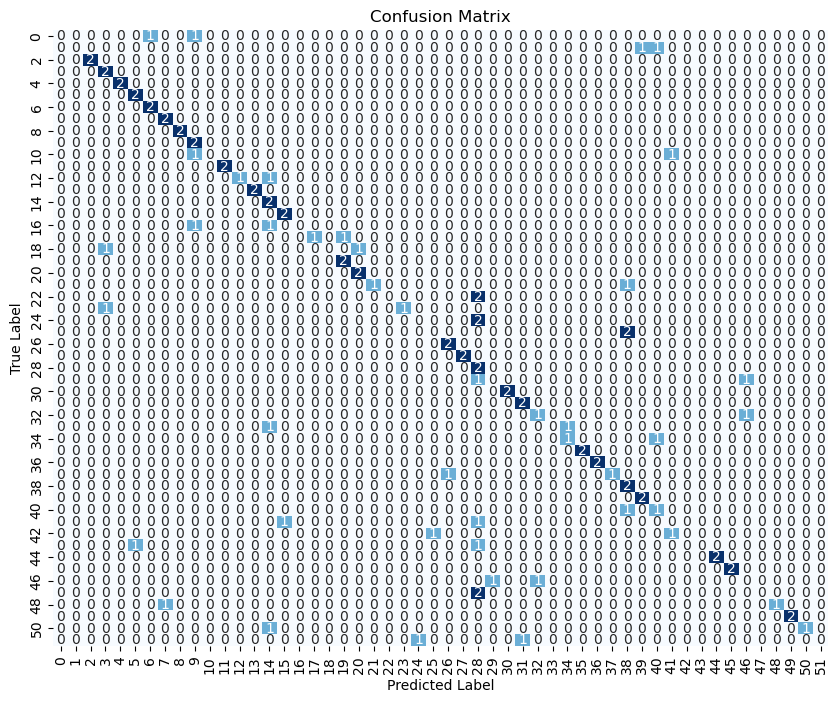

In [38]:
# Define the 1-Nearest Neighbor classifier with L1 distance (Manhattan distance)
M_pca = 100
M_lda = 50

nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

W_opt = PCA_LDA(x_train, y_train, M_pca, M_lda)
# projection of training images
x_train_proj = np.matmul(W_opt.T, x_train - overall_mean)
x_test_proj = np.matmul(W_opt.T, x_test - overall_mean)

nn.fit(x_train_proj.T, y_train.reshape(-1))

# Model prediction
y_pred = nn.predict(x_test_proj.T)

cm = confusion_matrix(y_test.T, y_pred)

# Confusion matrix 출력
print("Confusion Matrix:")
print(cm)

# Confusion matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

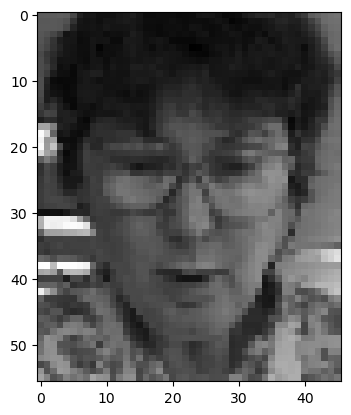

In [44]:
recon = overall_mean + np.matmul(W_opt, x_test_proj) 
image1 = np.reshape(x_test[:,0],(46,56)).T
plt.imshow(image1, cmap = 'gist_gray')

**Ensemble Learning**

N-1 eigenfaces

In [17]:
# Apply PCA_LDA
M_pca = x_train.shape[1] - 1 # 415
M_lda = x_train.shape[1] - 1 # 415

W_opt = PCA_LDA(x_train, y_train, M_pca, M_lda)
overall_mean = np.mean(x_train, axis=1).reshape(-1,1) #(2576, 1)
x_train_proj = np.matmul(W_opt.T, x_train - overall_mean) #(415, 416)
x_test_proj = np.matmul(W_opt.T, x_test - overall_mean) #(415, 104)

randomisation in feature space 

M0 개의 largest eigenvector<br/>
M1 개의 random eigenvector

In [ ]:
M0 = 50
M1 = 50

def PCA_LDA_random(x_train, y_train, M_0, M_1, M_lda):
    class_split_x_train = split_by_class(x_train, y_train)
    class_split_x_train = np.array(list(class_split_x_train.values()))
    
    class_mean = np.mean(class_split_x_train, axis=2) #(52,2576)
    overall_mean = np.mean(x_train, axis=1).reshape(-1,1) #(2576, 1)

    n_features = x_train.shape[0]
    Sb = np.zeros((n_features, n_features))
    Sw = np.zeros((n_features, n_features))

    # total scatter matrix
    T = x_train - overall_mean
    St = np.matmul(T, T.T) / (T.shape[1]-1)

    for i in range(class_split_x_train.shape[2]):
        X = class_split_x_train[i]
        N = X.shape[1]
        
        # between-class scatter matrix
        mean_diff = class_mean[i].reshape(-1, 1) - overall_mean #(2576, 1)
        Sb += N * (mean_diff).dot(mean_diff.T)
        # within-class scatter matrix
        for j in range(X.shape[1]):
            x = X[:, j]
            x = x.reshape(n_features, 1)
            mean = class_mean[i].reshape(n_features, 1)
            Sw += (x - mean).dot((x - mean).T)

    # PCA
    eigvals, eigvecs = np.linalg.eigh(St)
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices] #(2576,)
    eigvecs = eigvecs[:, sorted_indices] #(2576, 2576)
    indicies = np.concatenate((sorted_indices[:M0], np.random.choice(sorted_indices[M0:], M1)))
    W_pca = eigvecs[:, indicies] #(2576, M0+M1)
    
    # LDA
    S_lda = np.linalg.inv(W_pca.T @ Sw @ W_pca) @ (W_pca.T @ Sb @ W_pca)
    eigvals, eigvecs = np.linalg.eigh(S_lda)
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices] #(M_pca,)
    eigvecs = eigvecs[:, sorted_indices] #(M_pca, M_pca)
    W_lda = eigvecs[:, :M_lda] #(M_pca, M_lda)
    W_opt = np.matmul(W_pca, W_lda) #(2576, M_lda)

    return W_opt

Bagging<br/>
randomisation on data samples

데이터 쪼개고 나머진 안 건드려서 knn model 만들기

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

n_samples = 200
n_dataset = 4 # t=1,2,3,...,T

def bagging(x_train, y_train, n_samples, t):
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n_samples, random_state=t)
    # StratifiedShuffleSplit으로 샘플링
    for train_idx, _ in sss.split(x_train.T, y_train.reshape(-1)):
        x_resampled = x_train[:, train_idx]
        y_resampled = y_train[:, train_idx]
    return x_resampled, y_resampled

x_bagging = []
y_bagging = []
for t in range(n_dataset):
    x_resampled, y_resampled = bagging(x_train_proj, y_train, n_samples, i)
    x_bagging.append(x_resampled)
    y_bagging.append(y_resampled)
    
x_bagging =np.array(x_bagging) #(n_dataset, 415, n_samples)
y_bagging =np.array(y_bagging) #(n_dataset, 1, n_samples)

the number of base models

In [ ]:
n_models = 4 # t = 1,2,3,...T

the randomness parameter

In [ ]:
n_params = 10

Training

Fusion Rule

summation, multiplication, majority voting